In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rich_clust


In [117]:
from pathlib import Path
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import plotting_helpers, clustering, torch_helpers, math_functions, classification, indexing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
print(f'PyTorch version: {torch.__version__}')

PyTorch version: 1.12.0+cu113


In [5]:
import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt

import numpy as np

import functools 

In [6]:
n_clusters = 100
n_samples_per_cluster = 14

# fn_nSpC = lambda x : (torch.log(-(x-(n_samples_per_cluster+1)))**(2))
# fn_nSpC = lambda x : (torch.log(-(x-(n_samples_per_cluster+1)))**(2)) * 1
# fn_nSpC = lambda x, mu, a, b, c : c*(torch.exp(a*(x-mu)) - a*(x-mu) - 1)**b  ## Linex loss
# fn_nSpC = lambda x, mu, a : a * ( torch.nn.functional.softplus(-(x-mu), beta=1)*0 + torch.nn.functional.softplus((x-mu), beta=200)*10000 )
# fn_nSpC = lambda x, mu, a : a * ( torch.nn.functional.softplus((x-mu), beta=200)*1 + x*0.01)
fn_nSpC = lambda x, mu, a : a * ( torch.nn.functional.softplus((x-mu), beta=200)*1 + torch.tanh(x)*0)
# fn_nSpC = lambda x, mu, a : a * ( torch.nn.functional.relu(-(x-mu))*0 + torch.nn.functional.relu((x-mu))*10000 )
# p_nSpC = lambda x : fn_nSpC(x).mean()
# p_nSpC = lambda x : 0

# data, labels = sklearn.datasets.make_circles(n_samples=1000, noise=0.01, factor=0.4, shuffle=False)
# data, labels = sklearn.datasets.make_moons(n_samples=10000, shuffle=False, noise=0.1)

cluster_sizes = [14]
data_all = [sklearn.datasets.make_blobs(
    n_samples=n_clusters*n_samples_per_cluster, 
    n_features=2, 
    centers=n_clusters, 
    center_box=(-1,1), 
    shuffle=False, 
    cluster_std=torch.linspace(0.002, 0.02, n_clusters)
) for n_samples_per_cluster in cluster_sizes]
data = torch.cat([torch.as_tensor(val[0]) for val in data_all])
labels = torch.cat([torch.as_tensor(val[1]) + ii*n_clusters for ii,val in enumerate(data_all)])
# data = torch.as_tensor(data)

n_samples = data.shape[0]

# data, labels = sklearn.datasets.make_moons(n_samples=1000, noise=0.1)

<IPython.core.display.Javascript object>


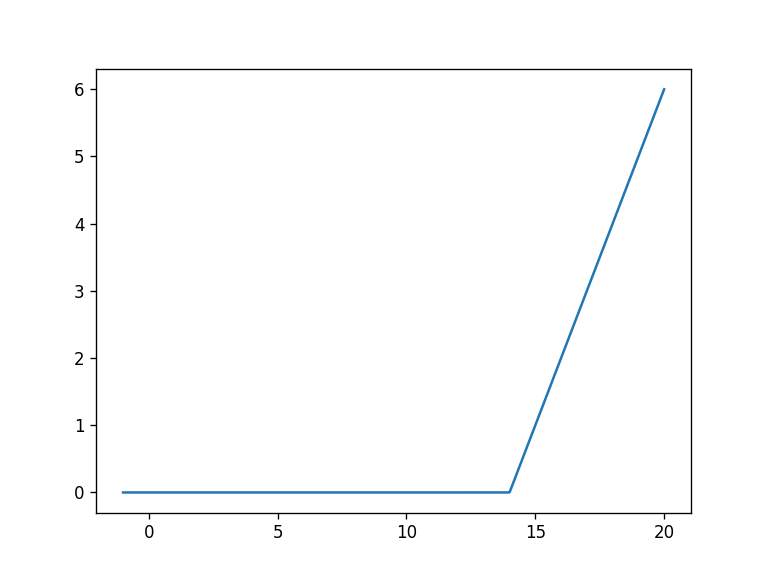

In [3395]:
x = torch.linspace(-1, 20, 1000)

plt.figure()
plt.plot(x, fn_nSpC(x, n_samples_per_cluster, 1))

In [3362]:
data.shape

torch.Size([1400, 2])

<IPython.core.display.Javascript object>


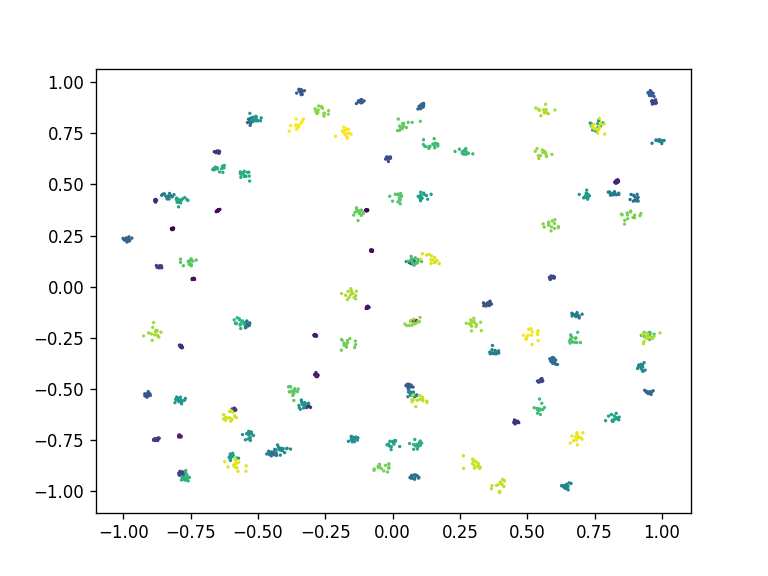

In [3363]:
plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels, s=1)

In [3364]:
d = torch.cdist(data, data, p=2).type(torch.float32)
s_tmp = torch.maximum(1-d*10, torch.as_tensor([0]))
p = (s_tmp==0).type(torch.float32)

s = s_tmp * torch.logical_not(torch.eye(s_tmp.shape[0]))

<IPython.core.display.Javascript object>


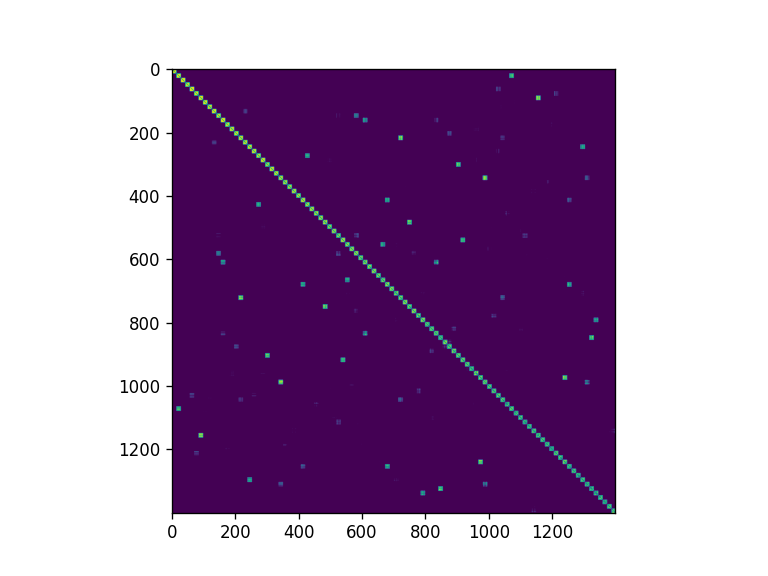

In [3365]:
plt.figure()
plt.imshow(s)

<IPython.core.display.Javascript object>


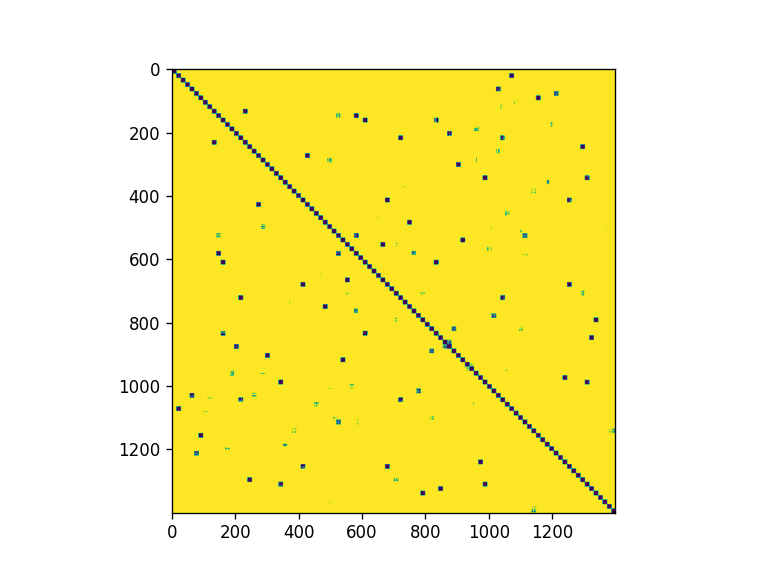

In [3367]:
plt.figure()
plt.imshow(p)

In [3397]:
optimizer_partial = functools.partial(
    torch.optim.Adam, 
    lr=0.002, 
    weight_decay=2*10**-7,
#     weight_decay=0.0,
)
# optimizer_partial = functools.partial(
#     torch.optim.SGD, 
#     lr=1000, 
#     weight_decay=1*10**-6,
# #     weight_decay=0,
#     momentum=0.00,
# )

# h_init = torch.rand(size=(s.shape[0], n_clusters+1))  ## Random initialization
# h_init = torch.ones(size=(s.shape[0], n_clusters+1)) * -0.1
# h_init = (h_init / h_init.sum(dim=0, keepdim=True)) * n_samples_per_cluster * 0.001
# h_init = (h_init / torch.nn.functional.softplus(h_init, beta=50, threshold=10).sum(dim=0, keepdim=True)) * n_samples_per_cluster


r_clust = clustering.rich_clust3(
    s=s,
    p=p*1,
    n_clusters=n_clusters*len(cluster_sizes)//2 + 0,
    n_wildClusters=1,
    penalty_wildClusters=1,
    penalty_ante=0,
    l=1,
#     p_nSpC=functools.partial(fn_nSpC, mu=n_samples_per_cluster, a=1, b=1, c=0.001),
#     p_nSpC=functools.partial(math_functions.Linex, mu=14, a=0.001, b=1, c=100, d=1.8),
    p_nSpC=functools.partial(fn_nSpC, mu=n_samples_per_cluster, a=10),
#     p_nSpC=lambda x : x*0,
    temp_h=1,
    temp_c=1,
    optimizer=optimizer_partial,
#     grad_clip=0.00000003,
    DEVICE='cuda:0',
#     init_h=h_init,
    init_h=None,
)

In [3417]:
r_clust.fit(n_iter=30000, verbose=True, verbose_interval=200)

iter: 19000:  loss_total: 3.6386   loss_cs: 3.1331  loss_nSpC: 0.0001  loss_p: 0.0036  loss_wildClusters: 0.5018
iter: 19200:  loss_total: 3.6383   loss_cs: 3.1329  loss_nSpC: 0.0001  loss_p: 0.0034  loss_wildClusters: 0.5019
iter: 19400:  loss_total: 3.6379   loss_cs: 3.1327  loss_nSpC: 0.0001  loss_p: 0.0032  loss_wildClusters: 0.5019
iter: 19600:  loss_total: 3.6377   loss_cs: 3.1324  loss_nSpC: 0.0001  loss_p: 0.0030  loss_wildClusters: 0.5021
iter: 19800:  loss_total: 3.6374   loss_cs: 3.1321  loss_nSpC: 0.0001  loss_p: 0.0029  loss_wildClusters: 0.5023
iter: 20000:  loss_total: 3.6371   loss_cs: 3.1319  loss_nSpC: 0.0001  loss_p: 0.0028  loss_wildClusters: 0.5024
iter: 20200:  loss_total: 3.6370   loss_cs: 3.1318  loss_nSpC: 0.0001  loss_p: 0.0026  loss_wildClusters: 0.5024
iter: 20400:  loss_total: 3.6368   loss_cs: 3.1317  loss_nSpC: 0.0001  loss_p: 0.0026  loss_wildClusters: 0.5024
iter: 20600:  loss_total: 3.6366   loss_cs: 3.1316  loss_nSpC: 0.0001  loss_p: 0.0025  loss_wild

iter: 33600:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 33800:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 34000:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 34200:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 34400:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 34600:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 34800:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 35000:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 35200:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wild

iter: 48200:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 48400:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 48600:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024
iter: 48800:  loss_total: 3.6357   loss_cs: 3.1312  loss_nSpC: 0.0001  loss_p: 0.0020  loss_wildClusters: 0.5024


<IPython.core.display.Javascript object>


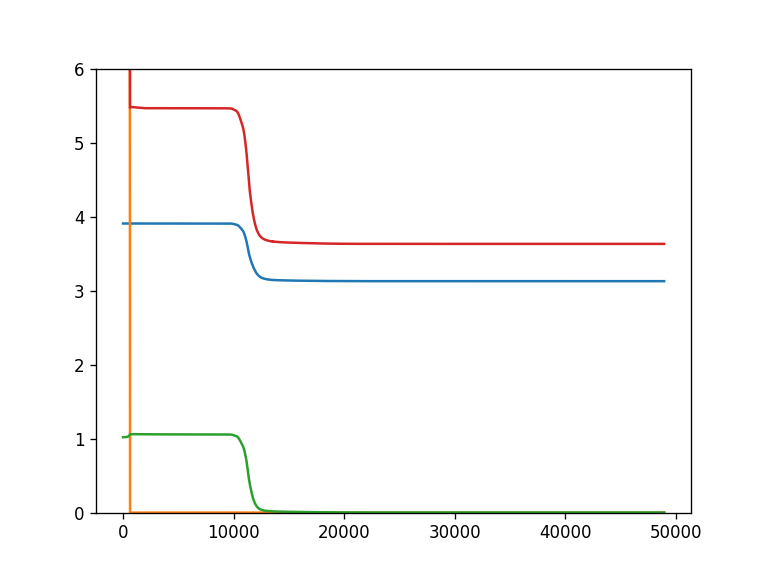

(0.0, 6.0)

In [3418]:
%matplotlib notebook

plt.figure()
plt.plot(r_clust.losses['L_cs'])
plt.plot(r_clust.losses['L_nSpC'])
plt.plot(r_clust.losses['L_p'])
plt.plot(r_clust.losses['L_total'])
plt.ylim([0,6])

<IPython.core.display.Javascript object>


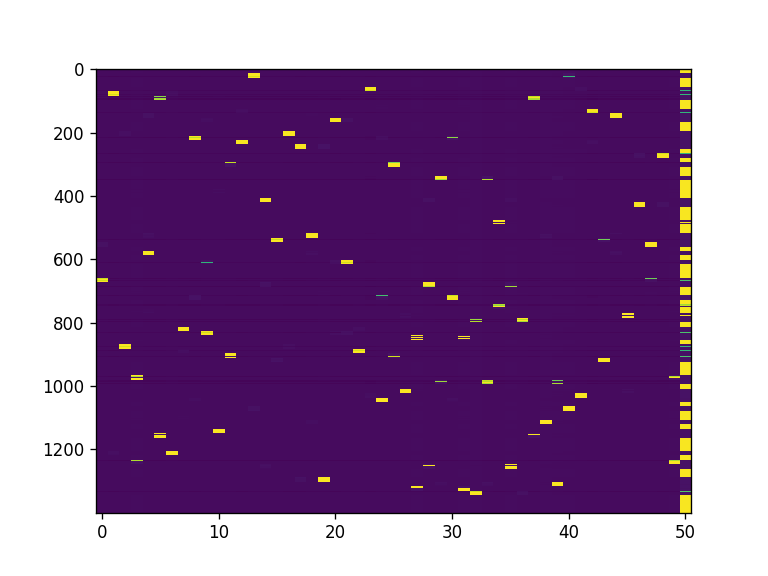

In [3419]:
%matplotlib notebook
plt.figure()
plt.imshow(r_clust.h.detach().cpu(), aspect='auto', interpolation='none')

<IPython.core.display.Javascript object>


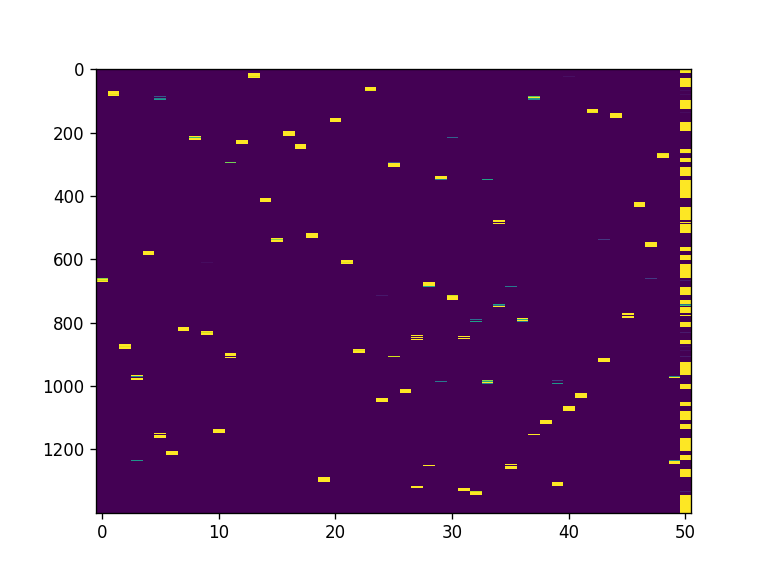

In [3420]:
%matplotlib notebook
plt.figure()
plt.imshow(r_clust.h_p.detach().cpu(), aspect='auto', interpolation='none', vmin=0, vmax=1)

<IPython.core.display.Javascript object>


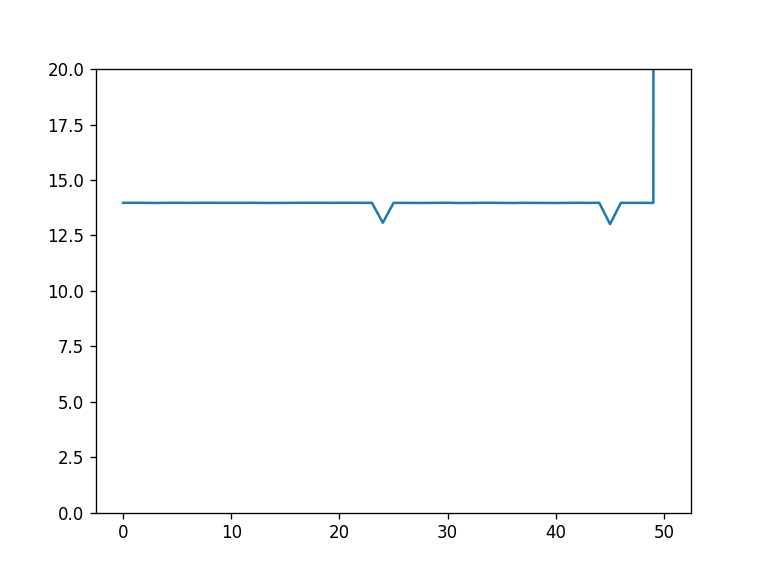

(0.0, 20.0)

In [3441]:
plt.figure()
plt.plot(r_clust.h_p.detach().cpu().sum(0))
# plt.yscale('log')
plt.ylim([0,20])

<IPython.core.display.Javascript object>


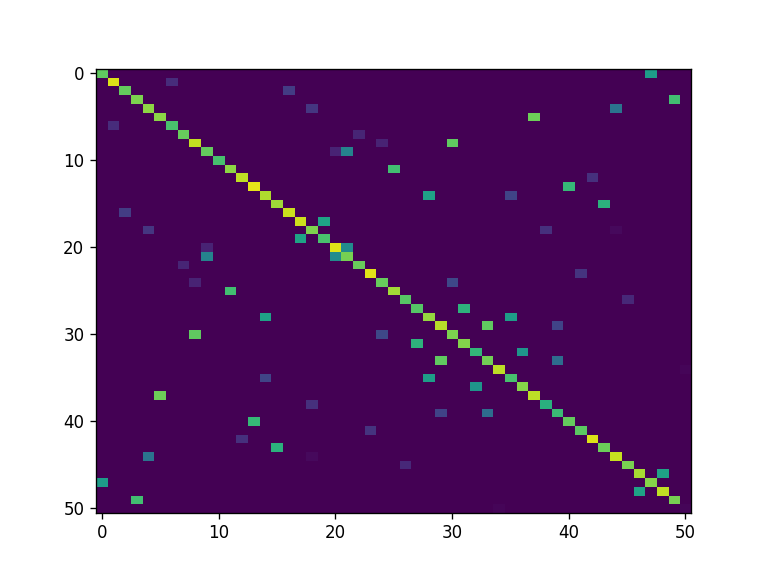

In [3442]:
%matplotlib notebook
plt.figure()
plt.imshow(r_clust.c.detach().cpu(), vmin=0, vmax=1, aspect='auto')

<IPython.core.display.Javascript object>


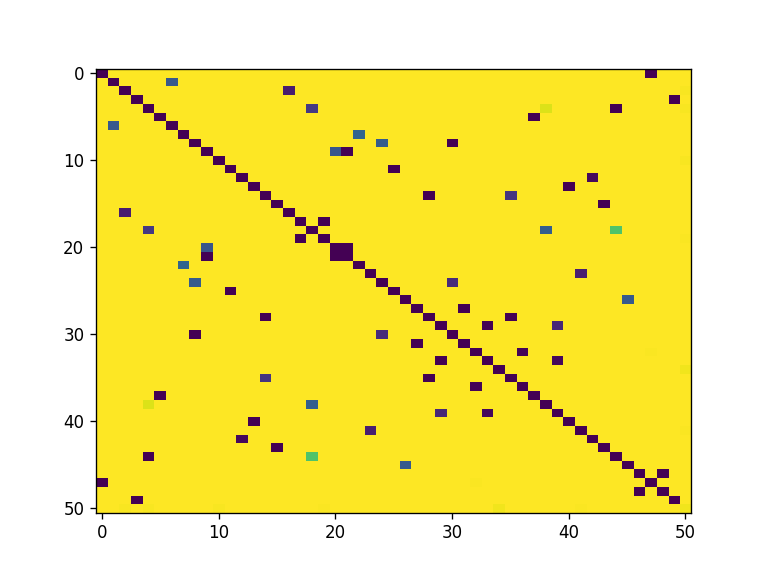

In [3443]:
%matplotlib notebook
plt.figure()
plt.imshow(r_clust.p_cs.detach().cpu(), aspect='auto', interpolation='none', vmin=0)

<IPython.core.display.Javascript object>


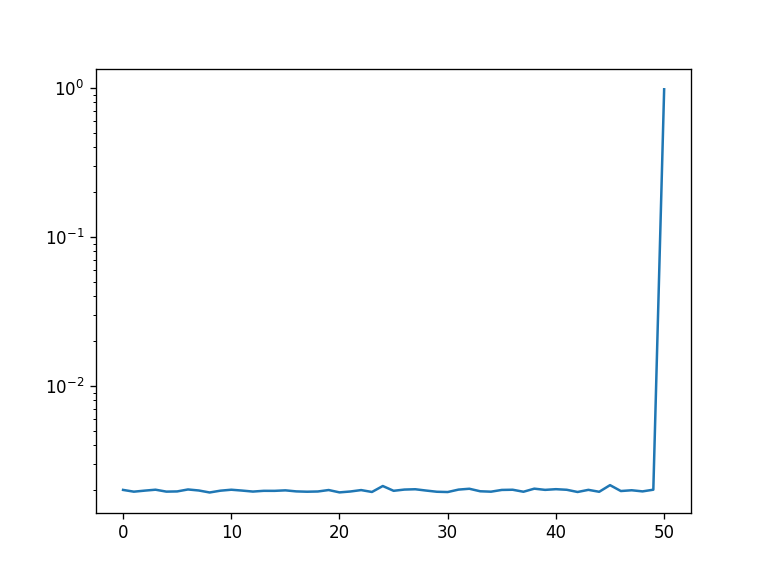

In [3444]:
plt.figure()
plt.plot(r_clust.p_cs.detach().cpu().diag())
plt.yscale('log')

<IPython.core.display.Javascript object>


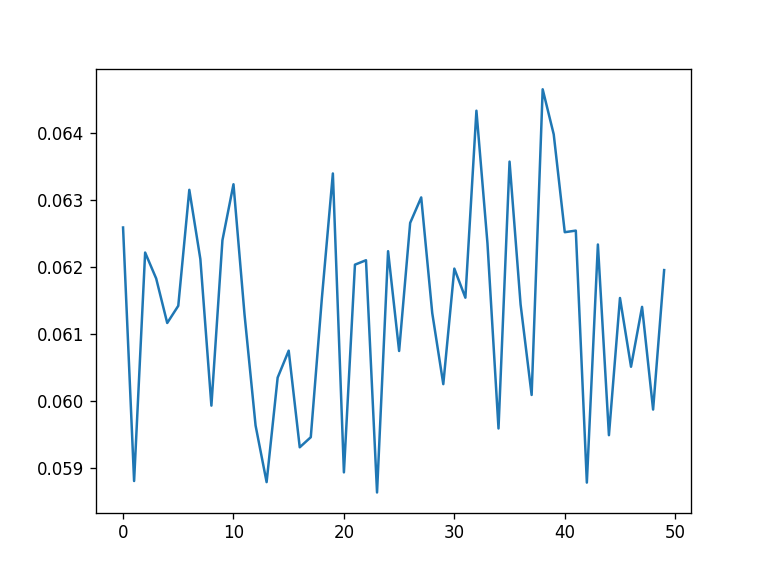

In [3445]:
test = (torch.nn.functional.cross_entropy(
                r_clust.c[:-r_clust.n_wildClusters, :-r_clust.n_wildClusters]/r_clust.temp_c, 
                torch.arange(r_clust.n_clusters).to(r_clust.DEVICE),
                reduction='none',
                ) * (torch.tanh(r_clust.h_p.sum(0))[:-r_clust.n_wildClusters] ** r_clust.penalty_ante)) / r_clust.c.shape[0]

plt.figure()
plt.plot(test.detach().cpu())

<IPython.core.display.Javascript object>


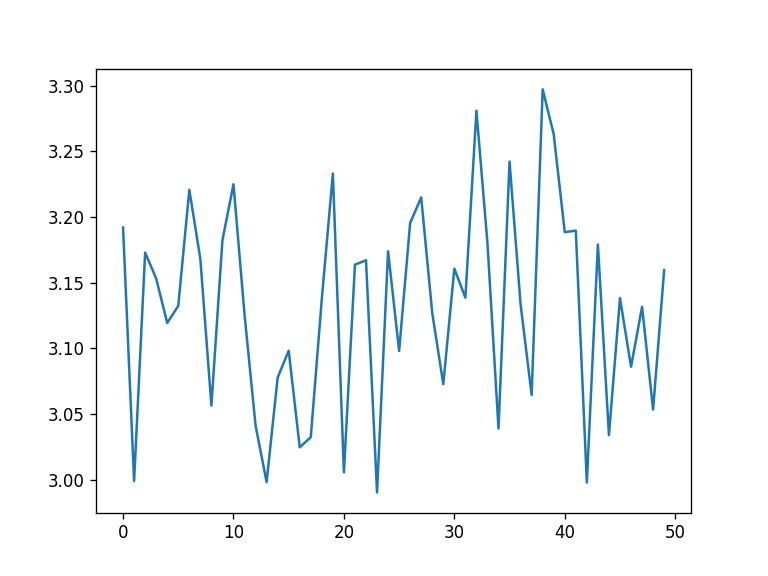

In [3446]:
test = torch.nn.functional.cross_entropy(
                r_clust.c[:-r_clust.n_wildClusters, :-r_clust.n_wildClusters]/r_clust.temp_c, 
                torch.arange(r_clust.n_clusters).to(r_clust.DEVICE),
                reduction='none',
                )

plt.figure()
plt.plot(test.detach().cpu())

<IPython.core.display.Javascript object>


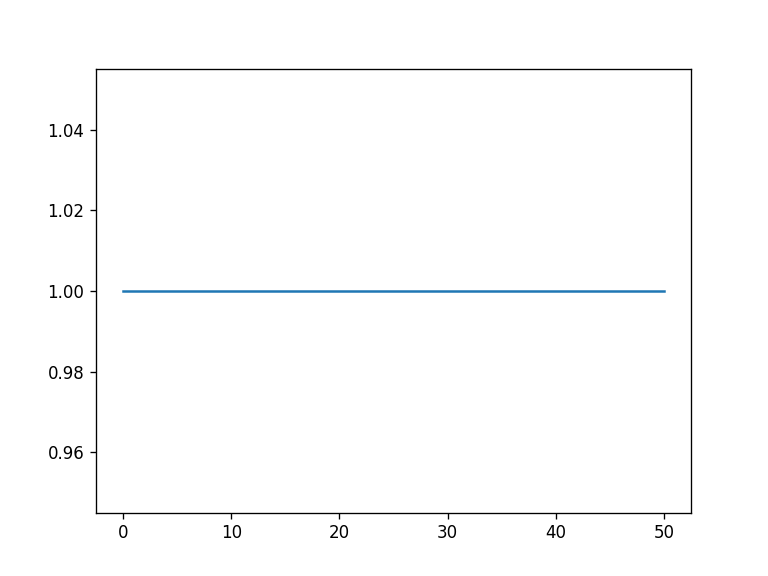

In [3447]:
test = torch.tanh(r_clust.h_p.sum(0))

plt.figure()
plt.plot(test.detach().cpu())

<IPython.core.display.Javascript object>


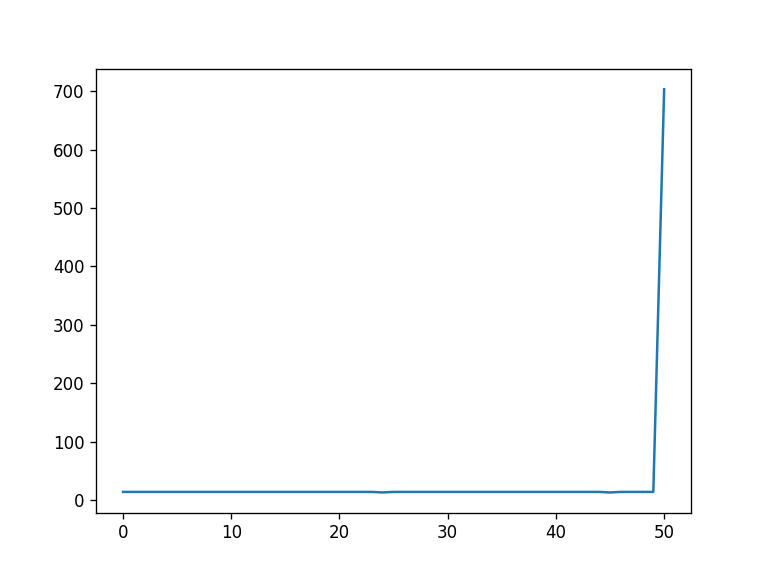

In [3448]:
test = r_clust.h_p.sum(0)

plt.figure()
plt.plot(test.detach().cpu())

In [506]:
colors_cmap = [
    [1,0,0],
    [1,0.6,0],
    [0.9,0.9,0],
    [0.6,1,0],
    [0,1,0],
    [0,1,0.6],
    [0,0.8,0.8],
    [0,0.6,1],
    [0,0,1],
    [0.6,0,1],
    [0.8,0,0.8],
    [1,0,0.6],
    ]

cmap = plotting_helpers.simple_cmap(np.concatenate([colors_cmap, np.array(colors_cmap)*0.8]),
    over=[0,0,0]
)

c_labels = cmap(tuple(torch.linspace(0.,1.00, r_clust.c.shape[0])))

NameError: name 'r_clust' is not defined

In [3450]:
r_clust.c.shape

torch.Size([51, 51])

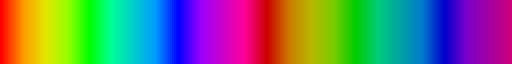

In [3451]:
cmap

In [3452]:
# h_p = r_clust.h_sm.detach().cpu()

preds = torch.argmax(r_clust.h_p, dim=1)
preds[preds == (r_clust.h_p.shape[1]-1)] = -1

confidence = ( r_clust.h_p.var(1) / r_clust.h_p.mean(1) ).detach().cpu()

<IPython.core.display.Javascript object>


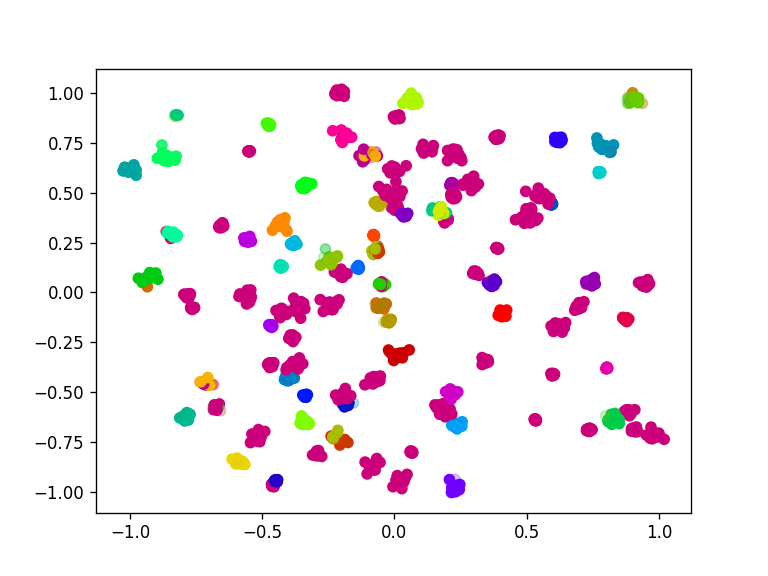

In [3453]:
colors = (r_clust.h_p.detach().cpu()@c_labels) / torch.max(r_clust.h_p.detach().cpu()@c_labels, dim=1)[0][:,None]
colors[:,3] = confidence**2

plt.figure()
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), c=colors)

<IPython.core.display.Javascript object>


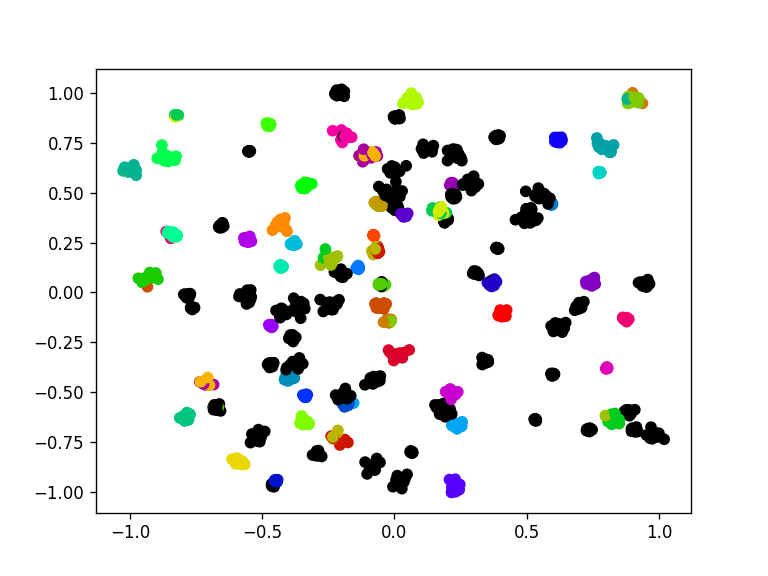

In [3454]:
colors = torch.as_tensor([cmap(val.item()) for val in (preds/r_clust.h_p.shape[1])])
# colors[:,3] = confidence**2

plt.figure()
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), c=colors)

<IPython.core.display.Javascript object>


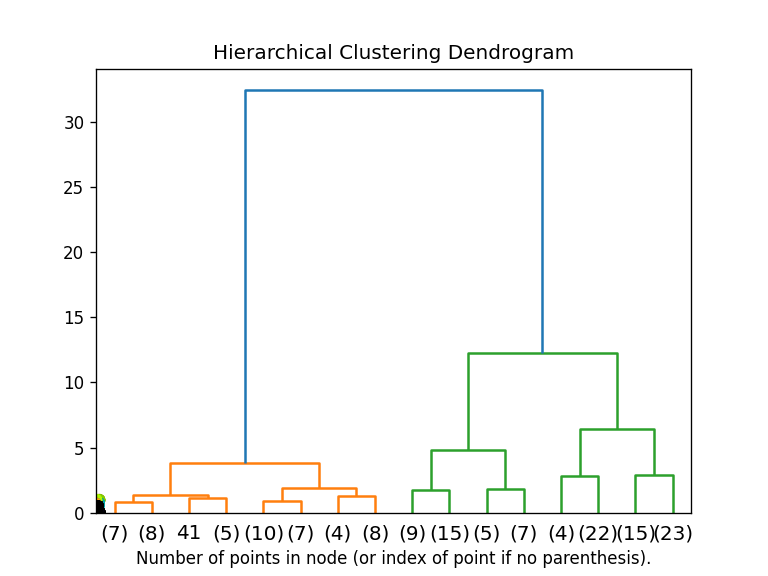

In [3435]:
colors = torch.as_tensor([cmap(val.item()) for val in (preds/r_clust.h_p.shape[1])])
# colors[:,3] = confidence > 0.5
colors[confidence < 0.7] = torch.as_tensor([0,0,0,0.1]).type(torch.DoubleTensor)

plt.figure()
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), c=colors)

<IPython.core.display.Javascript object>


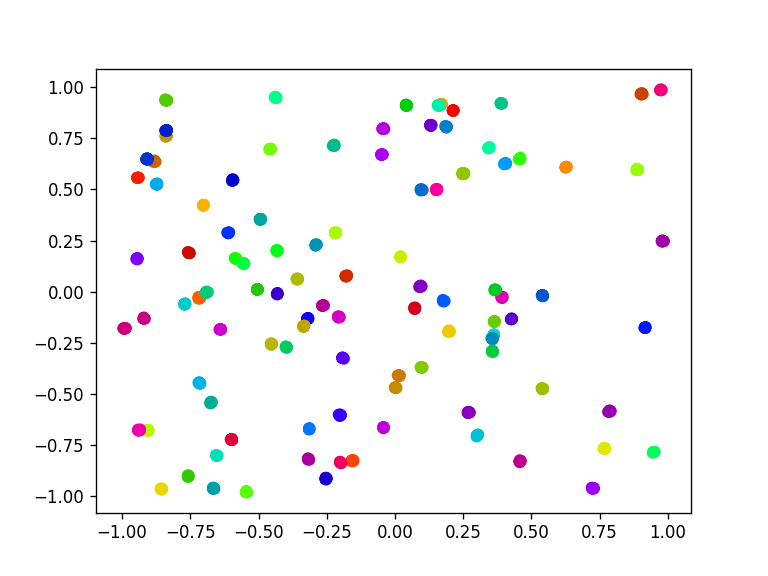

In [3358]:
plt.figure()
plt.scatter(data[:,0], data[:,1], c=cmap(labels/labels.max()))

In [3102]:
u, c = np.unique(preds.detach().cpu(), return_counts=True)

<IPython.core.display.Javascript object>


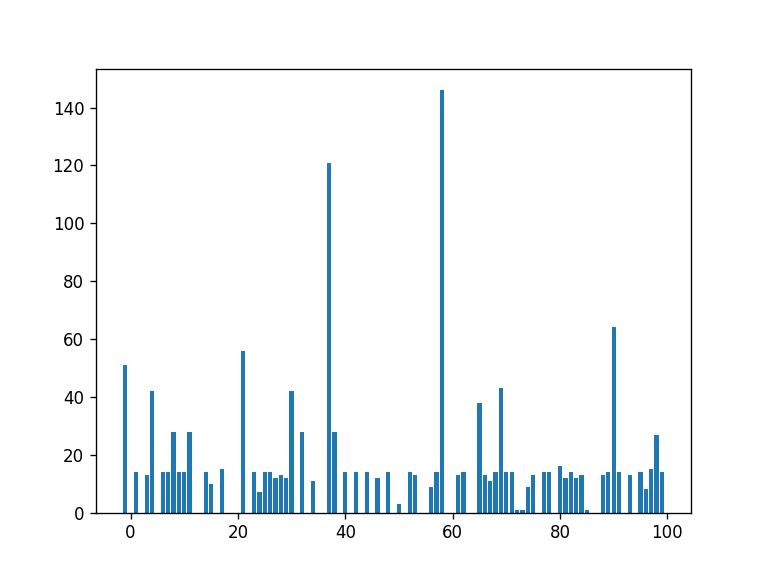

<BarContainer object of 68 artists>

In [3103]:
plt.figure()
# plt.hist(preds,300);
plt.bar(u, c)

<IPython.core.display.Javascript object>


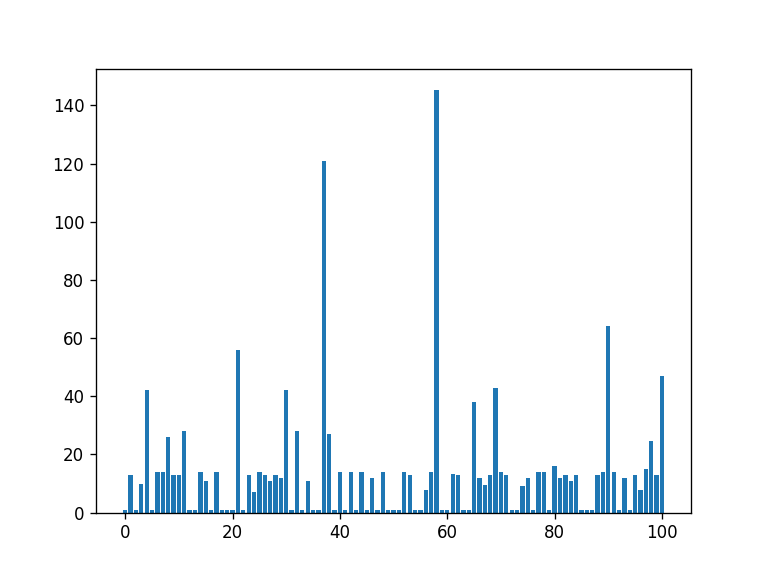

In [3104]:
plt.figure()
plt.bar(torch.arange(r_clust.h_p.shape[1]), r_clust.h_p.sum(0).detach().cpu());

<IPython.core.display.Javascript object>


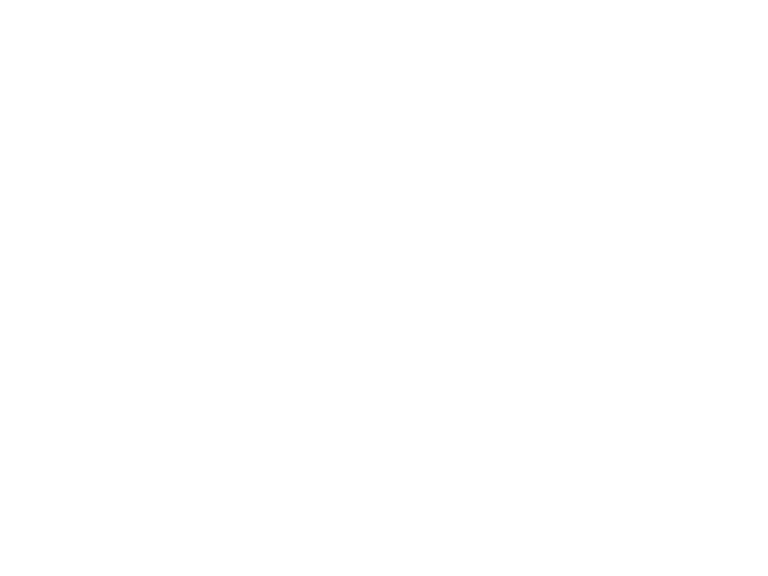

TypeError: <lambda>() takes 3 positional arguments but 5 were given

In [607]:
x = torch.linspace(-1, 30, 1000)

plt.figure()
# plt.plot(x, fn_nSpC(x))
plt.plot(x, fn_nSpC(x, 14, 1, 1, 1))
plt.ylim([0,50])
# plt.xlim([0,9])

In [ ]:
x = torch.linspace(-14, 50, 1000)

plt.figure()
# plt.plot(x, fn_nSpC(x))
plt.plot(x, functools.partial(math_functions.Linex, mu=20, a=0.001, b=1, c=100, d=1.8)(x))
# plt.plot(x, math_functions.Linex(x, mu=14, a=0.001, b=1, c=100, d=1.8))
plt.ylim([0,2])
# plt.xlim([0,9])

In [ ]:
x = torch.linspace(-14, 100, 10000)

plt.figure()
# plt.plot(x, fn_nSpC(x))
# plt.plot(x, functools.partial(math_functions.Linex, mu=0, a=0.001, b=2, c=2, d=6)(x))
plt.plot(x, functools.partial(math_functions.Linex, mu=14, a=1, b=2, c=0.01, d=1, e=0, f=0, g=1)(x))
# plt.plot(x, functools.partial(math_functions.Linex, mu=0, a=0.1, b=1, c=1, d=1)(x) + functools.partial(math_functions.Linex, mu=0, a=0.1, b=0.1, c=1, d=1)(x)*0.1)
# plt.plot(x, functools.partial(math_functions.Linex, mu=0, a=0.1, b=1, c=1, d=1)(x) + torch.abs(x)*1)
# plt.plot(x, math_functions.Linex(x, mu=14, a=0.001, b=1, c=100, d=1.8))
plt.ylim([0,50])
# plt.xlim([0,9])

In [ ]:
np.exp(1)

<IPython.core.display.Javascript object>


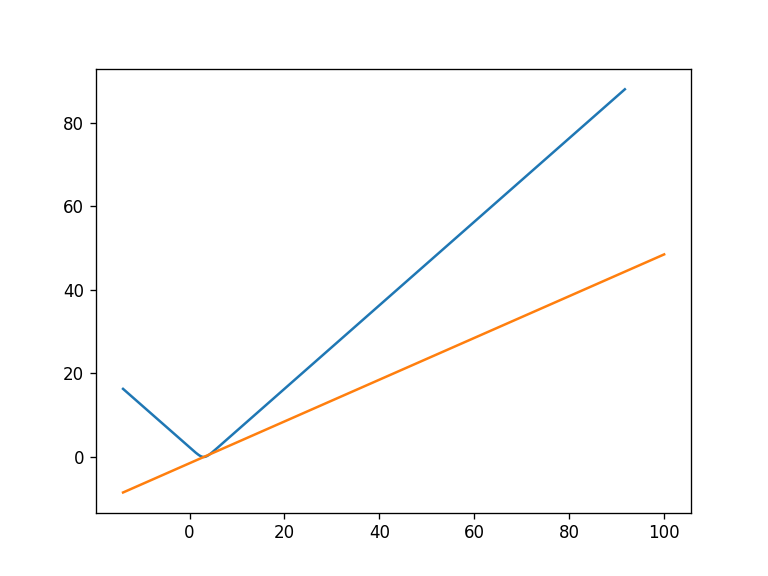

In [356]:
x = torch.linspace(-14, 100, 10000)

plt.figure()
# plt.plot(x, torch.log(torch.cosh(x-14))*1 + 0.002*(x-14)**3 -1)
plt.plot(x, torch.log(torch.cosh(x-3)*1)*1)
plt.plot(x, 0.5*(x-3)**1)
# plt.plot(x, torch.log(torch.cosh(x-3)*1)*1 + 1*(x-3)**2)


<IPython.core.display.Javascript object>


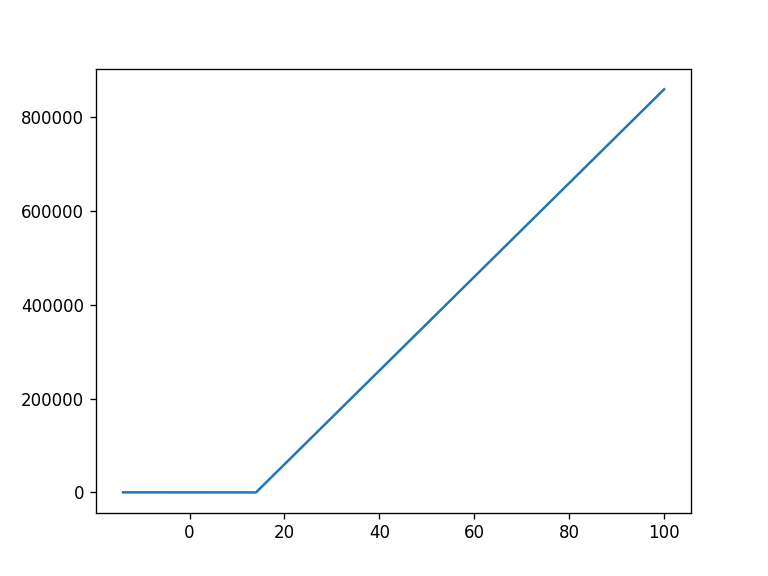

In [384]:
x = torch.linspace(-14, 100, 10000)

plt.figure()
# plt.plot(x, torch.log(torch.cosh(x-14))*1 + 0.002*(x-14)**3 -1)
# plt.plot(x, torch.log(torch.cosh(x-3)*1)*1)
# plt.plot(x, 0.5*(x-3)**1)

plt.plot(x, torch.nn.functional.softplus(-(x-14), beta=1)*10 + torch.nn.functional.softplus((x-14), beta=200)*10000)

# plt.ylim([0.5,1])
# plt.xlim([13.8,14.2])

<IPython.core.display.Javascript object>


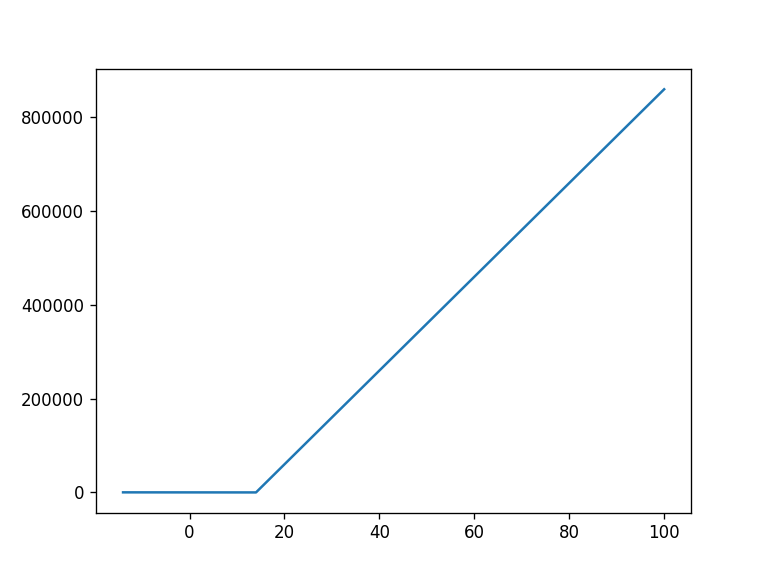

In [686]:
x = torch.linspace(-14, 100, 10000)

plt.figure()
# plt.plot(x, torch.log(torch.cosh(x-14))*1 + 0.002*(x-14)**3 -1)
# plt.plot(x, torch.log(torch.cosh(x-3)*1)*1)
# plt.plot(x, 0.5*(x-3)**1)

plt.plot(x, torch.nn.functional.relu(-(x-14))*0 + torch.nn.functional.relu((x-14))*10000)

# plt.ylim([0.5,1])
# plt.xlim([13.8,14.2])

<IPython.core.display.Javascript object>


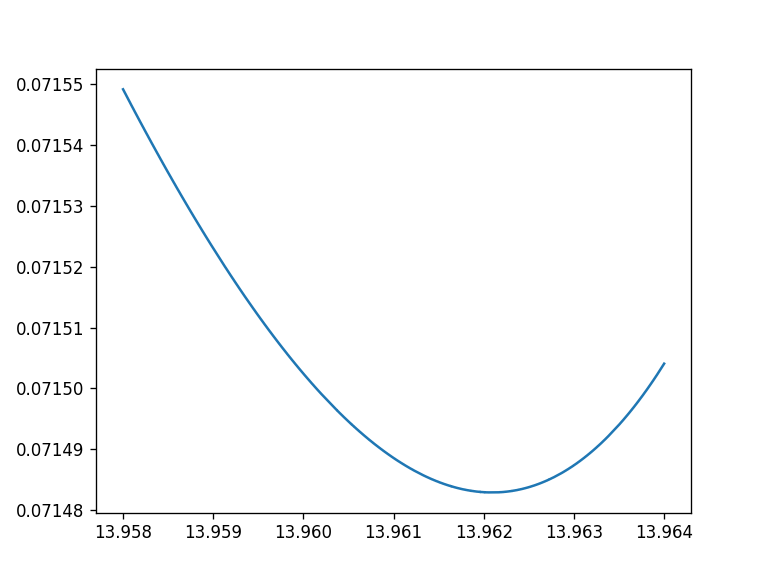

In [640]:
x = torch.linspace(13.958, 13.964, 100000)

plt.figure()
plt.plot(x, fn_nSpC(x, 14, 0.01))

<IPython.core.display.Javascript object>


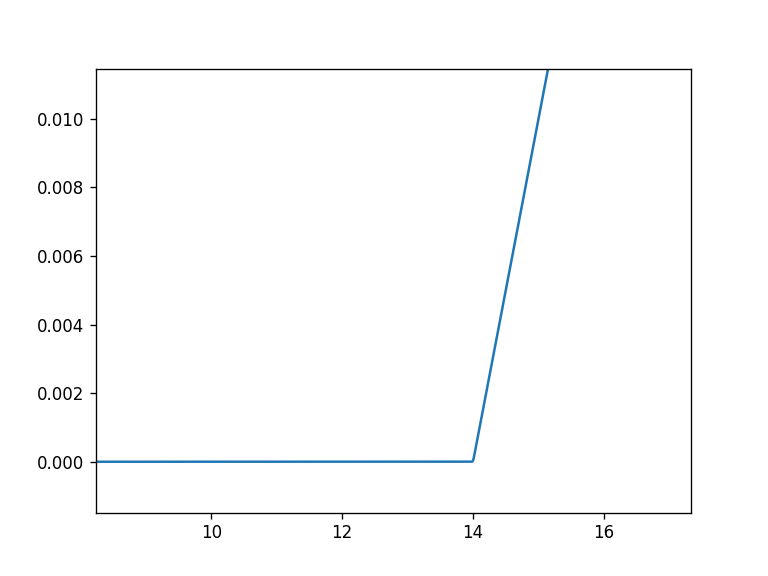

In [861]:
x = torch.linspace(-1, 20, 10000)

plt.figure()
plt.plot(x, fn_nSpC(x, 14, 0.01))

In [1897]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rich_clust


In [1898]:
from pathlib import Path
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import plotting_helpers, clustering, torch_helpers, math_functions, classification, indexing, linear_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1899]:
import torch
print(f'PyTorch version: {torch.__version__}')

PyTorch version: 1.12.0+cu113


In [1900]:
import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt

import numpy as np

import functools 
import copy

In [1901]:
import scipy
import scipy.spatial
import scipy.cluster

In [1902]:
n_clusters = 100
n_samples_per_cluster = 14

# data, labels = sklearn.datasets.make_circles(n_samples=1000, noise=0.01, factor=0.4, shuffle=False)
# data, labels = sklearn.datasets.make_moons(n_samples=10000, shuffle=False, noise=0.1)

cluster_sizes = [14]
data_all = [sklearn.datasets.make_blobs(
    n_samples=n_clusters*n_samples_per_cluster, 
    n_features=2, 
    centers=n_clusters, 
    center_box=(-1,1), 
    shuffle=False, 
    cluster_std=torch.linspace(0.002, 0.02, n_clusters)
) for n_samples_per_cluster in cluster_sizes]
data = torch.cat([torch.as_tensor(val[0]) for val in data_all])
labels = torch.cat([torch.as_tensor(val[1]) + ii*n_clusters for ii,val in enumerate(data_all)])
# data = torch.as_tensor(data)

n_samples = data.shape[0]

# data, labels = sklearn.datasets.make_moons(n_samples=1000, noise=0.1)

In [1903]:
labels

tensor([ 0,  0,  0,  ..., 99, 99, 99])

<IPython.core.display.Javascript object>


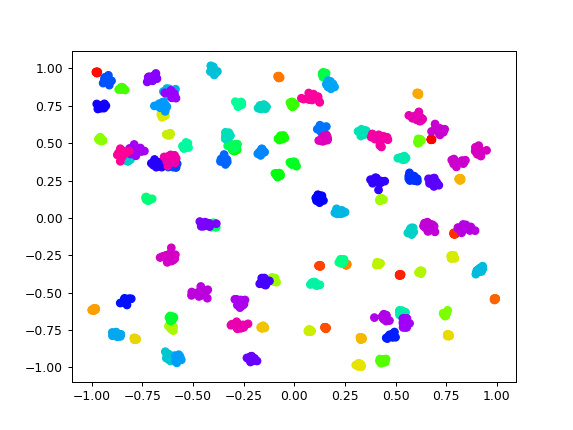

In [1904]:
plt.figure()
plt.scatter(data[:,0], data[:,1], c=plotting_helpers.simple_cmap()(labels/labels.max()))

<IPython.core.display.Javascript object>


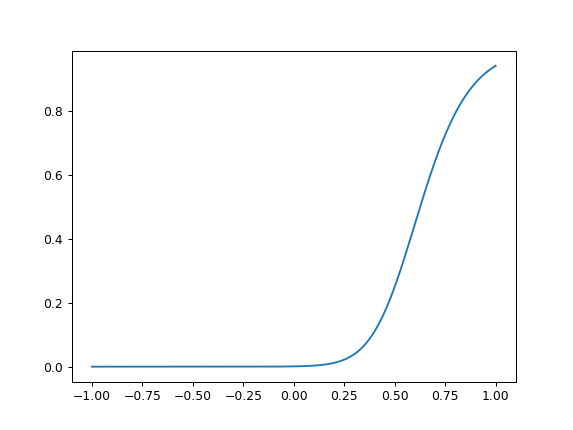

In [1905]:
x=torch.linspace(-1,1, 1000)

sigmoid = functools.partial(
    math_functions.generalised_logistic_function, 
#     x=x,
    a=0,
    k=1,
    b=7,
    v=0.5,
    q=1,
    c=1,
    mu=0.5,
)

plt.figure()
plt.plot(x, sigmoid(x))

In [1908]:
d = torch.as_tensor(scipy.spatial.distance.squareform(torch.pdist(data, p=2).type(torch.float32).numpy()))
s_tmp = torch.maximum(1-d*1, torch.as_tensor([0]))
p = (s_tmp==0).type(torch.float32)

s = sigmoid(s_tmp)
s *= torch.logical_not(torch.eye(s_tmp.shape[0]))
s[s<0.01] = 0
s -= s.min()
s /= s.max()

<IPython.core.display.Javascript object>


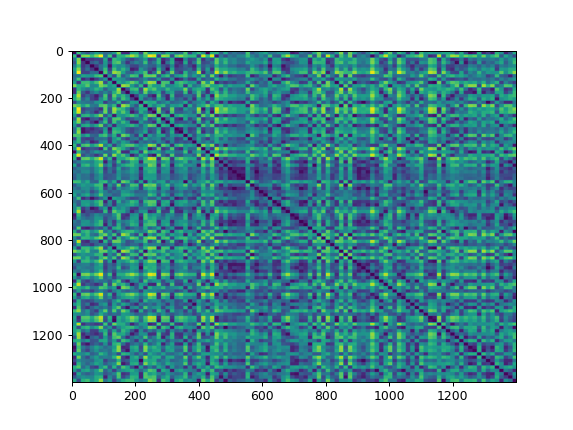

<IPython.core.display.Javascript object>


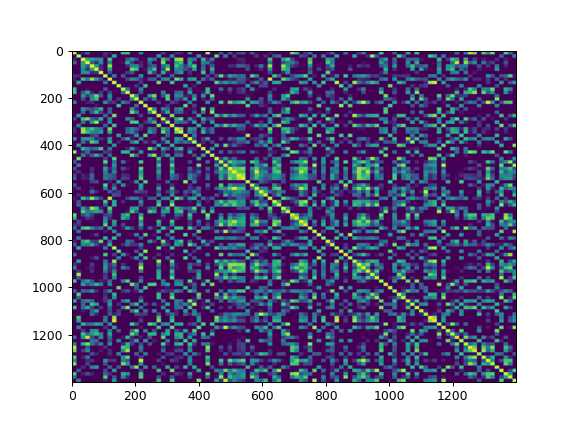

<IPython.core.display.Javascript object>


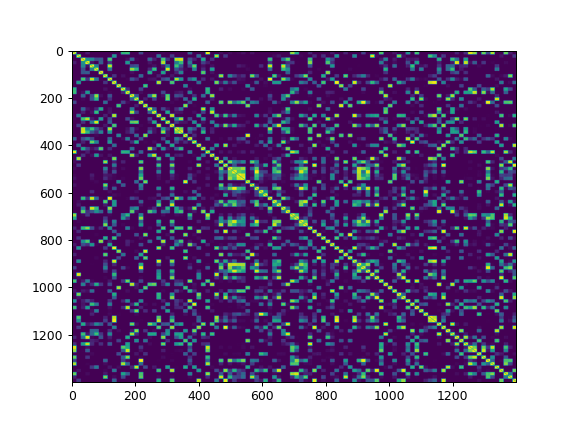

In [1909]:
plt.figure()
plt.imshow(d, aspect='auto')

plt.figure()
plt.imshow(s_tmp, aspect='auto')

plt.figure()
plt.imshow(s, aspect='auto')

In [1910]:
link_methods = ['single', 'complete', 'ward', 'average']
links = {method : scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(d), method=method) for method in link_methods}

def display_clustering_widget(
    embeddings, 
    min_samples, 
    max_samples=None,
    min_slider=0.01,
    max_slider=5, 
    start_slider=1.0,
    single_color=False,
    ):

    from ipywidgets import interact, widgets
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=10)
    # sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

    def get_val_counts(vals):
        vals_unique = np.unique(vals)
        vals_counts = np.zeros_like(vals, dtype=np.int64)
        for ii, val in enumerate(vals_unique):
            vals_counts[vals==val] = np.sum(vals==val)
        return vals_counts
    def update(t=1):
        t_toUse = t/10000
        
#         # Compute DBSCAN
#         db = sklearn.cluster.DBSCAN(
#             eps=eps_toUse,
#             min_samples=min_samples, 
#     #         metric='manhattan',
#             metric_params=None, 
#             algorithm='auto',
#             leaf_size=30, 
#             p=2, 
#             n_jobs=-1
#         ).fit(embeddings)

#         labels = db.labels_
#     #     labels = db.labels_ - db.labels_.min()
    
        labels = scipy.cluster.hierarchy.fcluster(links['average'], t=t_toUse, criterion='distance')
        
        if max_samples is not None:
            labels[get_val_counts(labels) > max_samples] = -1

        if single_color:
            cmap = rand_cmap(2, verbose=False)
        else:
            cmap = rand_cmap(len(np.unique(labels)), verbose=False)

        if len(np.unique(labels)) == 1:
            print('Eps value gives one big cluster. Adjust')
        else:
            sc.set_color(cmap(squeeze_integers(labels)+1))

            fig.canvas.draw_idle()
            ax.set_title(f'eps={round(t_toUse,3)}, n_clusters={len(np.unique(labels))}')
            print(np.unique(labels))

    interact(update, t=widgets.IntSlider(min=min_slider, max=max_slider, step=1, value=start_slider));
#     interact(update, t=widgets.IntSlider(min=0, max=200, step=1, value=1));
    

rand_cmap = plotting_helpers.rand_cmap
squeeze_integers = classification.squeeze_integers

In [1911]:
cmap = plotting_helpers.rand_cmap(nlabels=n_clusters, verbose=False)

# c_labels = cmap(tuple(torch.linspace(0.,1., len(labels))))

<IPython.core.display.Javascript object>


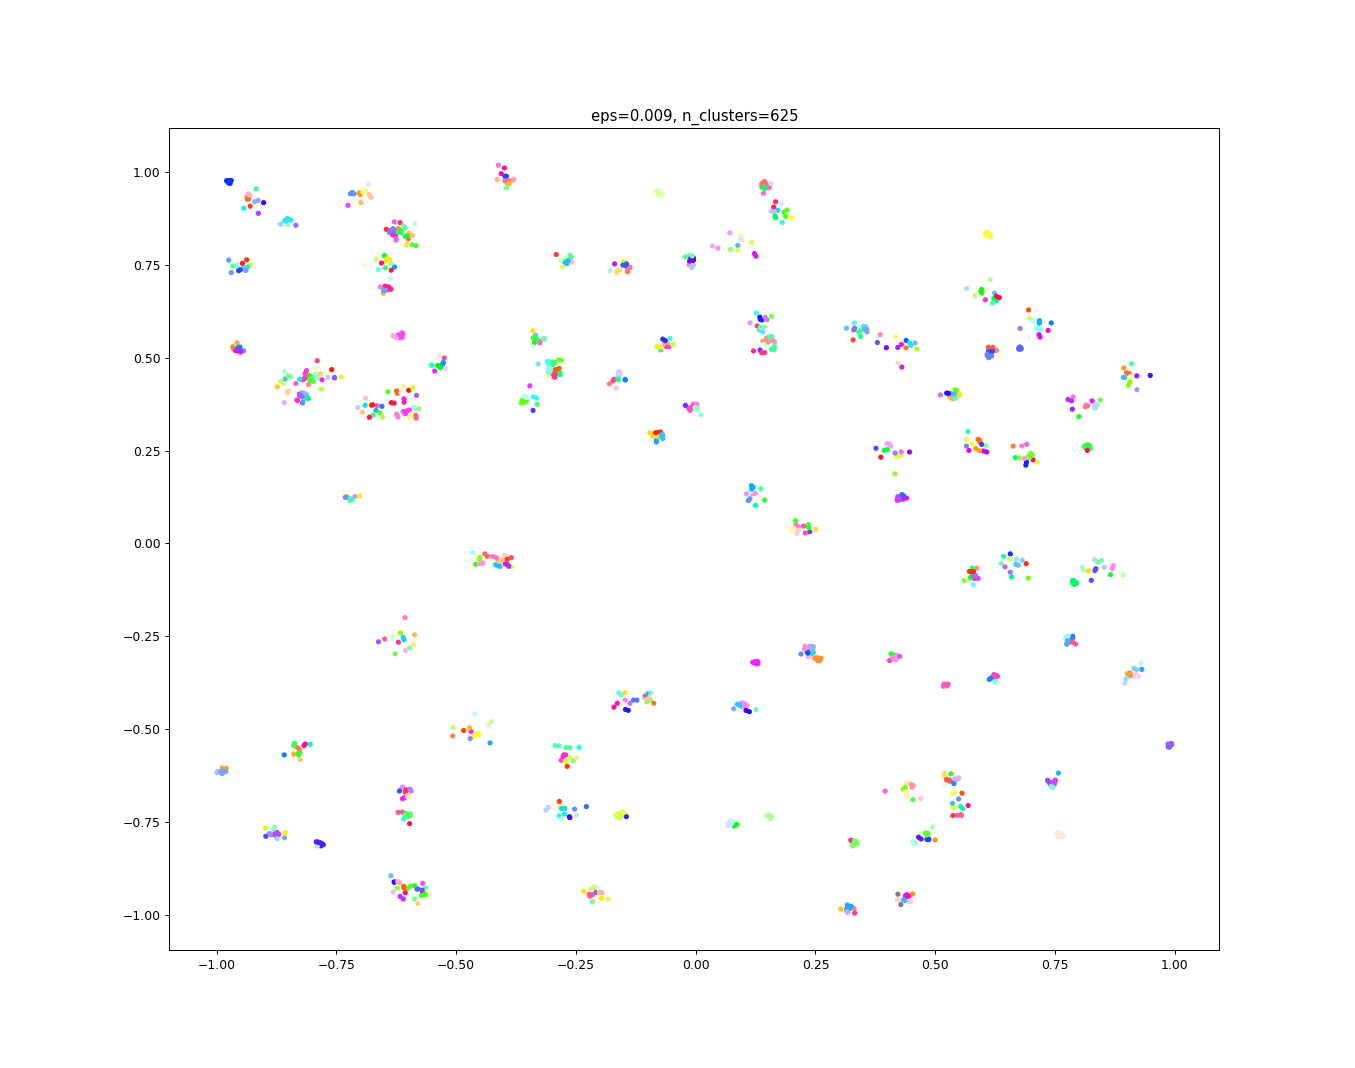

interactive(children=(IntSlider(value=1, description='t', max=1000), Output()), _dom_classes=('widget-interact…

In [1912]:
%matplotlib notebook

display_clustering_widget(
    embeddings=data, 
    min_samples=2, 
    max_samples=None,
    min_slider=0,
    max_slider=1000, 
    start_slider=1,
    single_color=False,
    )

In [1913]:
sweep_t_vals = math_functions.bounded_logspace(0.01, 0.08, 200)

In [1914]:
def _labels_to_idx(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return [np.where(labels==label)[0] for label in np.unique(labels)]

def _labels_to_bool(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return np.array([labels==label for label in np.unique(labels)])

def _freq_of_values(vals):
    u = np.unique(vals)
    f = np.array([np.sum(vals==unique) for unique in u])
    return np.array([f[u==val][0] for val in vals])




cluster_idx = []
for ii, t in enumerate(sweep_t_vals):
#     labels_link = scipy.cluster.hierarchy.fcluster(link, t=t, criterion='distance')
    
#     # concatenate the indices of clusters found at this eps value to a big list
#     [cluster_idx.append(idx) for idx in _labels_to_bool(labels_link)]

    
#     labels_link = scipy.cluster.hierarchy.fcluster(link, t=t, criterion='distance')
    
#     # concatenate the indices of clusters found at this eps value to a big list
#     [cluster_idx.append(idx) for idx in _labels_to_bool(labels_link)]

    [cluster_idx.append(_labels_to_bool(scipy.cluster.hierarchy.fcluster(links[method], t=t, criterion='distance'))) for method in link_methods]
cluster_idx = np.concatenate(cluster_idx, axis=0)

In [1915]:
# clusterHashes_block = [hash(tuple(vec)) for vec in cluster_idx]
# u, idx, c = np.unique(
#     ar=clusterHashes_block,
#     return_index=True,
#     return_counts=True,
# )

u, idx, c = np.unique(
    ar=np.packbits(np.array(cluster_idx), axis=1),
    axis=0,
    return_index=True,
    return_counts=True,
)
# clusters_idx_unique, clusters_idx_unique_freq = np.unique(cluster_idx, axis=0, return_counts=True)

clusters_idx_unique = np.array(cluster_idx, dtype=np.bool8)[idx]
clusters_idx_unique_freq = c

In [1916]:
min_samples = 2
max_samples = n_samples_per_cluster

# sizes_clusters_raw = np.array([len(idx) for idx in clusters_idx_unique], dtype=np.int64)
sizes_clusters_raw = clusters_idx_unique.sum(1)
# print(clusters_idx_unique)

bool_tooSmall = (sizes_clusters_raw < min_samples).astype(np.bool8)
bool_tooBig = (sizes_clusters_raw > max_samples).astype(np.bool8)

idx_toDelete = bool_tooSmall + bool_tooBig

## remove clusters with too few samples
clusters_idx_unique = clusters_idx_unique[np.logical_not(idx_toDelete),:]
clusters_idx_unique_freq = clusters_idx_unique_freq[np.logical_not(idx_toDelete)]

# clusters_idx_unique = np.delete(clusters_idx_unique, idx_toDelete)
# clusters_idx_unique_freq = np.delete(clusters_idx_unique_freq, idx_toDelete)

In [1917]:
h = torch.stack([torch.as_tensor(indexing.idx2bool(idx, length=n_samples), dtype=torch.float32) for idx in clusters_idx_unique], dim=0).T.type(torch.bool)

In [1922]:
from tqdm.notebook import tqdm

In [1960]:
c_score = clustering.cluster_dispersion_score(s,h)

269557it [01:03, 4240.33it/s] 
100%|██████████████████████████████| 1904400/1904400 [01:27<00:00, 21662.87it/s]


tensor([[0.4981, 0.9962, 0.9899,  ..., 0.1858, 0.1918, 0.0000],
        [0.9962, 0.6628, 0.9899,  ..., 0.1858, 0.1918, 0.0000],
        [0.9899, 0.9899, 0.6657,  ..., 0.1447, 0.1497, 0.0000],
        ...,
        [0.1858, 0.1858, 0.1447,  ..., 0.9154, 0.9998, 0.0000],
        [0.1918, 0.1918, 0.1497,  ..., 0.9998, 0.9270, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9275]])

In [1953]:
c_sil = clustering.cluster_silhouette_score(s,h)

<IPython.core.display.Javascript object>


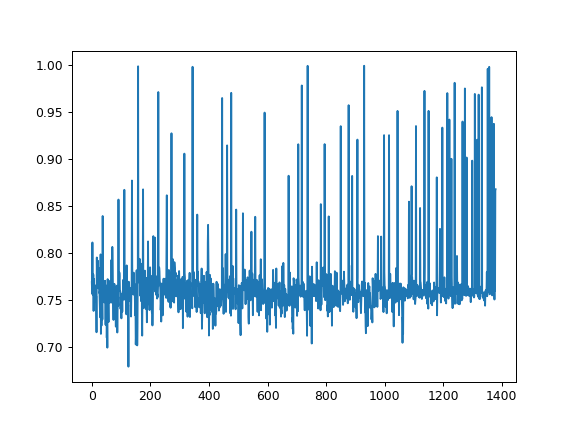

In [1927]:
plt.figure()
plt.plot(c_sil)

In [1324]:
c_redundant = ( (torch.einsum('ab, ac, bd -> cd', torch.eye(h.shape[0], dtype=torch.torch.float32), h.type(torch.float32), h.type(torch.float32))>0) * (torch.logical_not(torch.eye(h.shape[1]))) ).type(torch.bool)

In [1928]:
w = ((h.cpu().sum(0) / 14)**2) * (c_sil.cpu()**4)

<IPython.core.display.Javascript object>


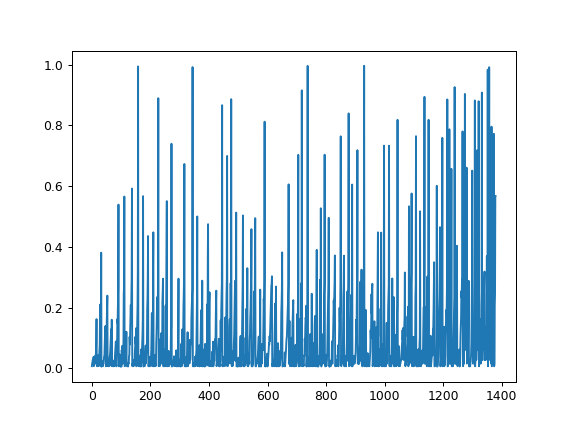

In [1929]:
plt.figure()
plt.plot(w.cpu())
# plt.ylim([0,1.1])

In [1930]:
DEVICE = 'cuda:0'

s = s.to(DEVICE)
h = h.to(DEVICE).type(torch.float32)

In [1963]:
# c = (c_max*1 + c_mean*1)/2 + c_redundant*0
c = c_max
# c = c_max + c_redundant*1
# c = c_local*1
# c = c_sum
# c = c_mean
# c = c_local
# c = c_sum + c_redundant*2

c2 = copy.copy(c)**0.5
# c2[c2==0] = -15
# c2 = torch.ones_like(c2)

c = c2.to(DEVICE)

# c=torch.zeros_like(c)

crc = clustering.Constrained_rich_clustering(
    c,
    h,
    w.to(DEVICE),
    m_init=(torch.ones(c.shape[0])*-2 + torch.rand(c.shape[0])*1).type(torch.float32).to(DEVICE),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-2, betas=(0.9, 0.900)),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e1,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e0,
    maskL1_penalty=0e-2,
    tol_convergence=1e-8,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

[autoreload of basic_neural_processing_modules.clustering failed: Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/pytho

In [1932]:
crc.fit(
    min_iter=1e3,
    max_iter=1e5,
    verbose=True, 
    verbose_interval=100
)

iter: 0:  loss_total: 0.5374   loss_cs: 0.0167  loss_fracWeighted: 0.5207  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 100:  loss_total: 0.4860   loss_cs: 0.0254  loss_fracWeighted: 0.4606  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 200:  loss_total: 0.3972   loss_cs: 0.0554  loss_fracWeighted: 0.3415  loss_sampleWeight: 0.0002  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 300:  loss_total: 0.3256   loss_cs: 0.0663  loss_fracWeighted: 0.2592  loss_sampleWeight: 0.0001  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 400:  loss_total: 0.3025   loss_cs: 0.0721  loss_fracWeighted: 0.2303  loss_sampleWeight: 0.0001  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 500:  loss_total: 0.2989   loss_cs: 0.0733  loss_fracWeighted: 0.2255  loss_sampleWeight: 0.0002  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 600:  loss_total: 0.2984   loss_cs: 0.0734  loss

<IPython.core.display.Javascript object>


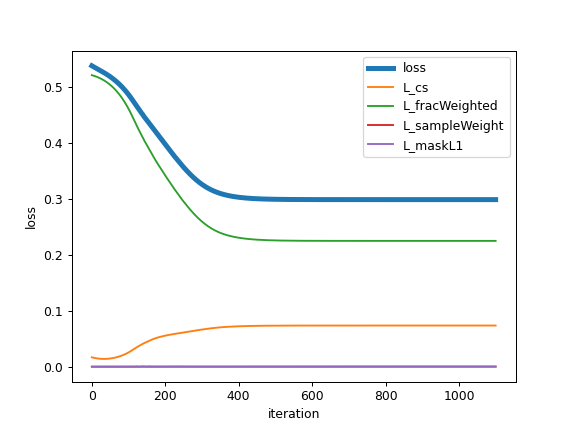

In [1933]:
crc.plot_loss()

<IPython.core.display.Javascript object>


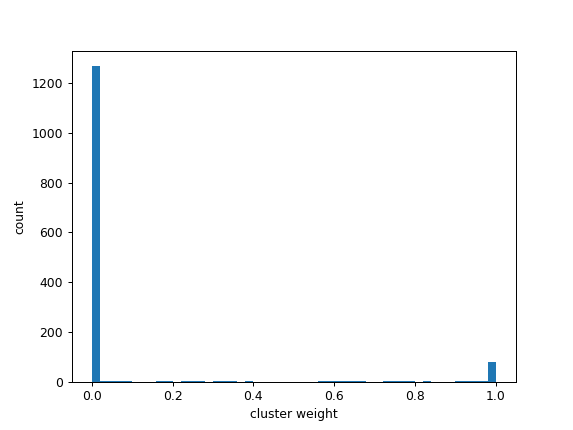

In [1934]:
crc.plot_clusterWeights(plot_raw_m=False)

<IPython.core.display.Javascript object>


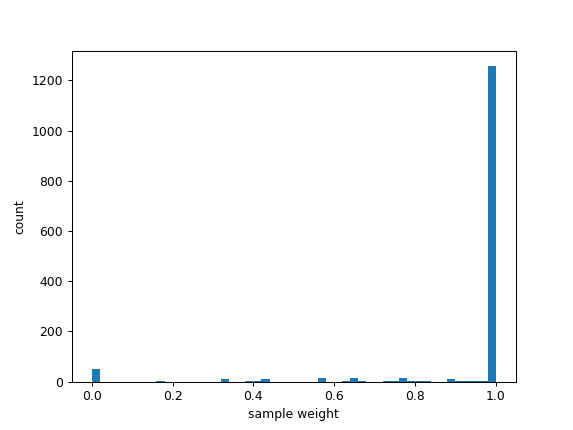

In [1935]:
crc.plot_sampleWeights()

In [1936]:
m_threshold=0.5

preds, confidence = crc.predict(m_threshold=m_threshold)

<IPython.core.display.Javascript object>


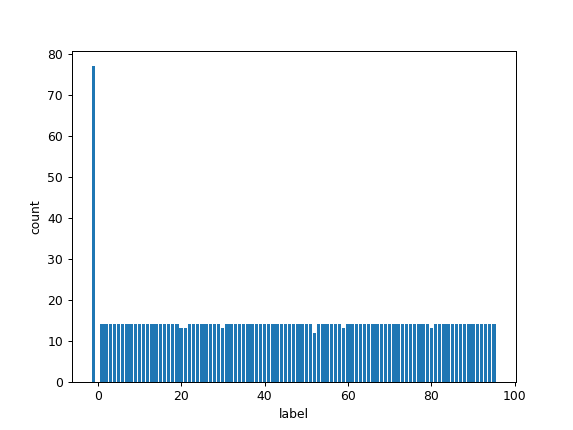

In [1937]:
crc.plot_labelCounts()

<IPython.core.display.Javascript object>


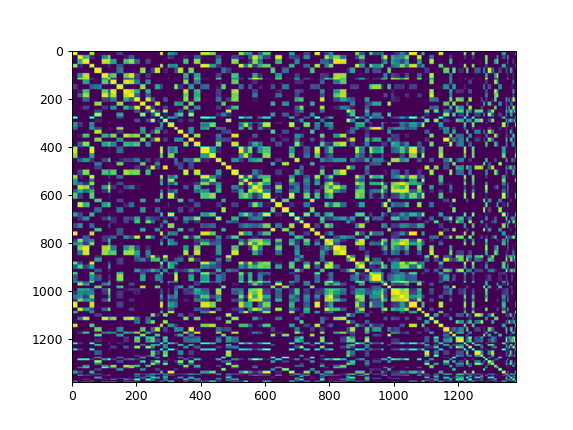

In [1938]:
plt.figure()
plt.imshow(crc.c.cpu(), aspect='auto')

<IPython.core.display.Javascript object>


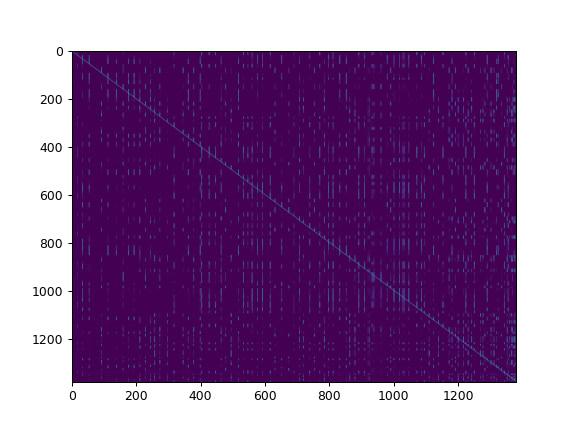

In [1939]:
# c_test = (crc.c.cpu() * crc.m[None,:].cpu()).cpu()
c_test = (crc.c.cpu() * crc.activate_m()[None,:].cpu()).cpu()
c_test[crc._dmCEL.idx_diag, crc._dmCEL.idx_diag] = crc.c.diag().cpu()
# c_test = torch.nn.functional.log_softmax(c_test/crc._dmCEL.temp, dim=1)
# c_test = torch.nn.functional.log_softmax(c_test/0.01, dim=1)

plt.figure()
plt.imshow(c_test.detach().cpu(), aspect='auto')

<IPython.core.display.Javascript object>


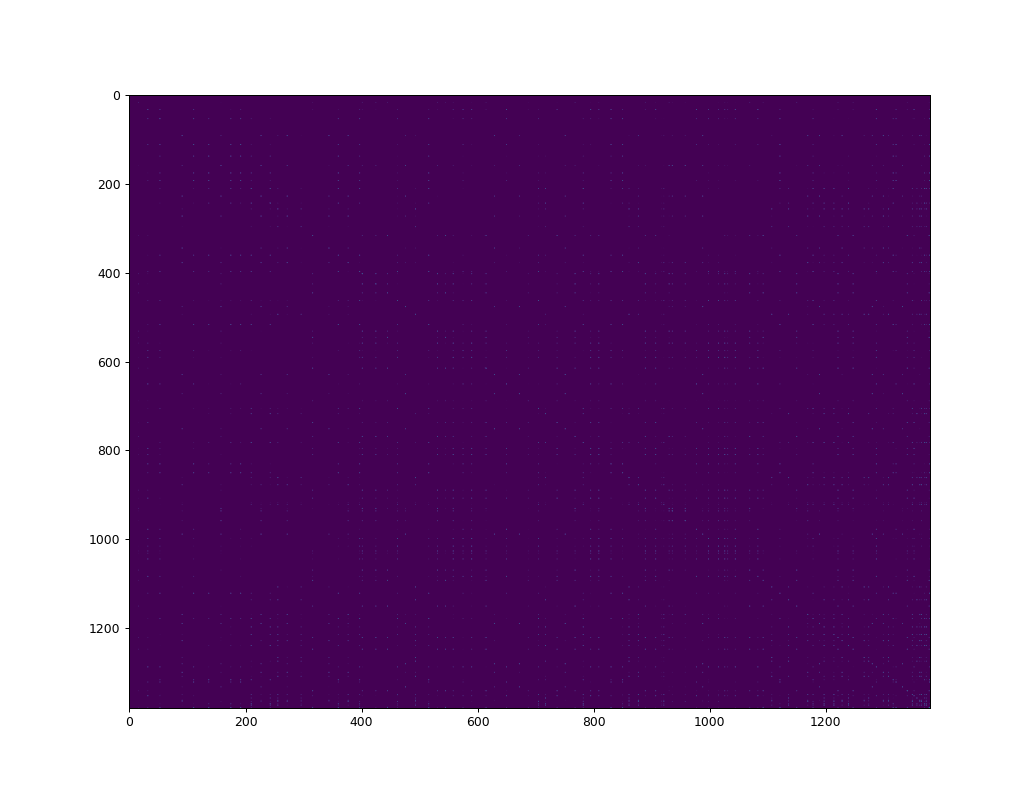

In [1940]:
crc.plot_c_masked_matrix()

<IPython.core.display.Javascript object>


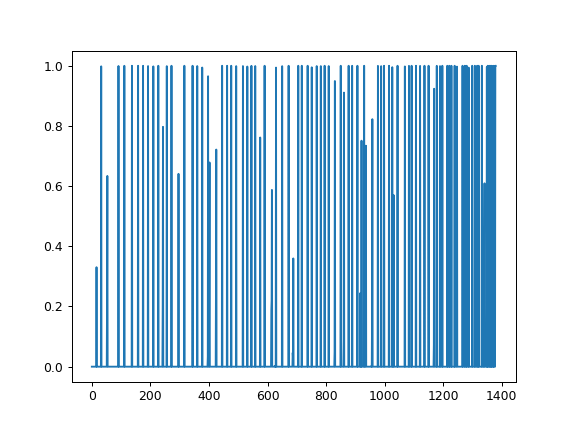

In [1941]:
plt.figure()
plt.plot(crc.activate_m().detach().cpu())

<IPython.core.display.Javascript object>


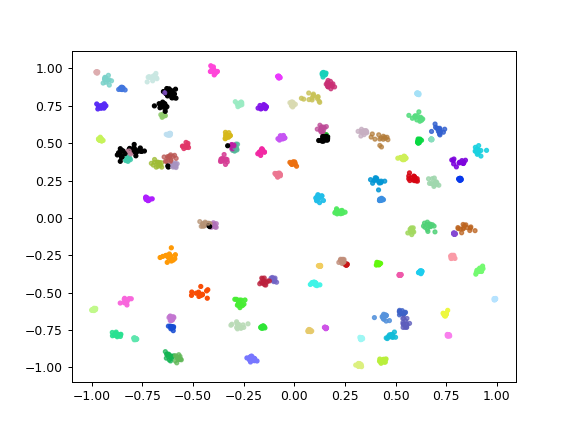

In [1943]:
cmap = plotting_helpers.rand_cmap(nlabels=h.shape[1], first_color_black=False, last_color_black=False, verbose=False)
# cmap = plotting_helpers.simple_cmap(under=[0.0,0.0,0.0])
colors = cmap(list((preds/torch_helpers.nanmax(preds)).numpy()))
# colors = cmap(list((preds/torch.nanmedian(preds)).numpy()))

# colors[:,3] = confidence

sc_sil = (h.cpu() * c_sil.cpu()[None,:] * (crc.activate_m()>0.5).cpu()).max(1)[0]
colors = colors * (sc_sil/sc_sil.max()).numpy()[:,None]

colors[confidence < m_threshold] = [0,0,0,1]

plt.figure()
# plt.scatter(data[:,0], data[:,1], s=10, c=plotting_helpers.simple_cmap(under=[0.0,0.0,0.0])(preds/torch_helpers.nanmax(preds)))
plt.scatter(data[:,0], data[:,1], s=10, c=colors)

<IPython.core.display.Javascript object>


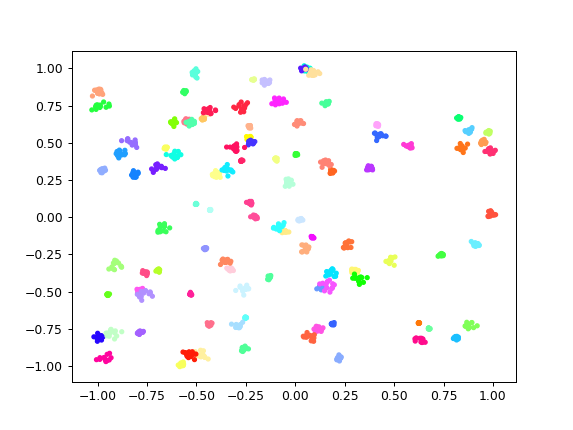

In [1861]:
plt.figure()
# plt.scatter(data[:,0], data[:,1], c=plotting_helpers.simple_cmap(under=[0.9,0.9,0.9])(preds/torch_helpers.nanmax(preds)))
plt.scatter(data[:,0], data[:,1], s=10, c=plotting_helpers.rand_cmap(nlabels=len(labels),first_color_black=False, last_color_black=False, verbose=False)(labels/labels.max()))

In [89]:
import pandas as pd


In [125]:
test = pd.read_csv(filepath_or_buffer='/media/rich/bigSSD/downloads_tmp/HistoricalData_1658087928616.csv')

In [126]:
test = pd.DataFrame(np.flipud(test), columns=test.columns)

In [128]:
test['Open'] = test['Open'].str.replace('$', '').astype(np.float32)

/tmp/ipykernel_1979421/938691911.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['Open'] = test['Open'].str.replace('$', '').astype(np.float32)


In [129]:
opens = test['Open']

In [130]:
opens

0      133.440002
1      130.839996
2      134.339996
3      132.660004
4      128.039993
          ...    
119    176.949997
120    177.339996
121    176.380005
122    176.789993
123    176.050003
Name: Open, Length: 124, dtype: float32

In [ ]:
May 26 (abstracts drop) 
June 3-7 (presentations)
June 14 - 7 days after presentations

<IPython.core.display.Javascript object>


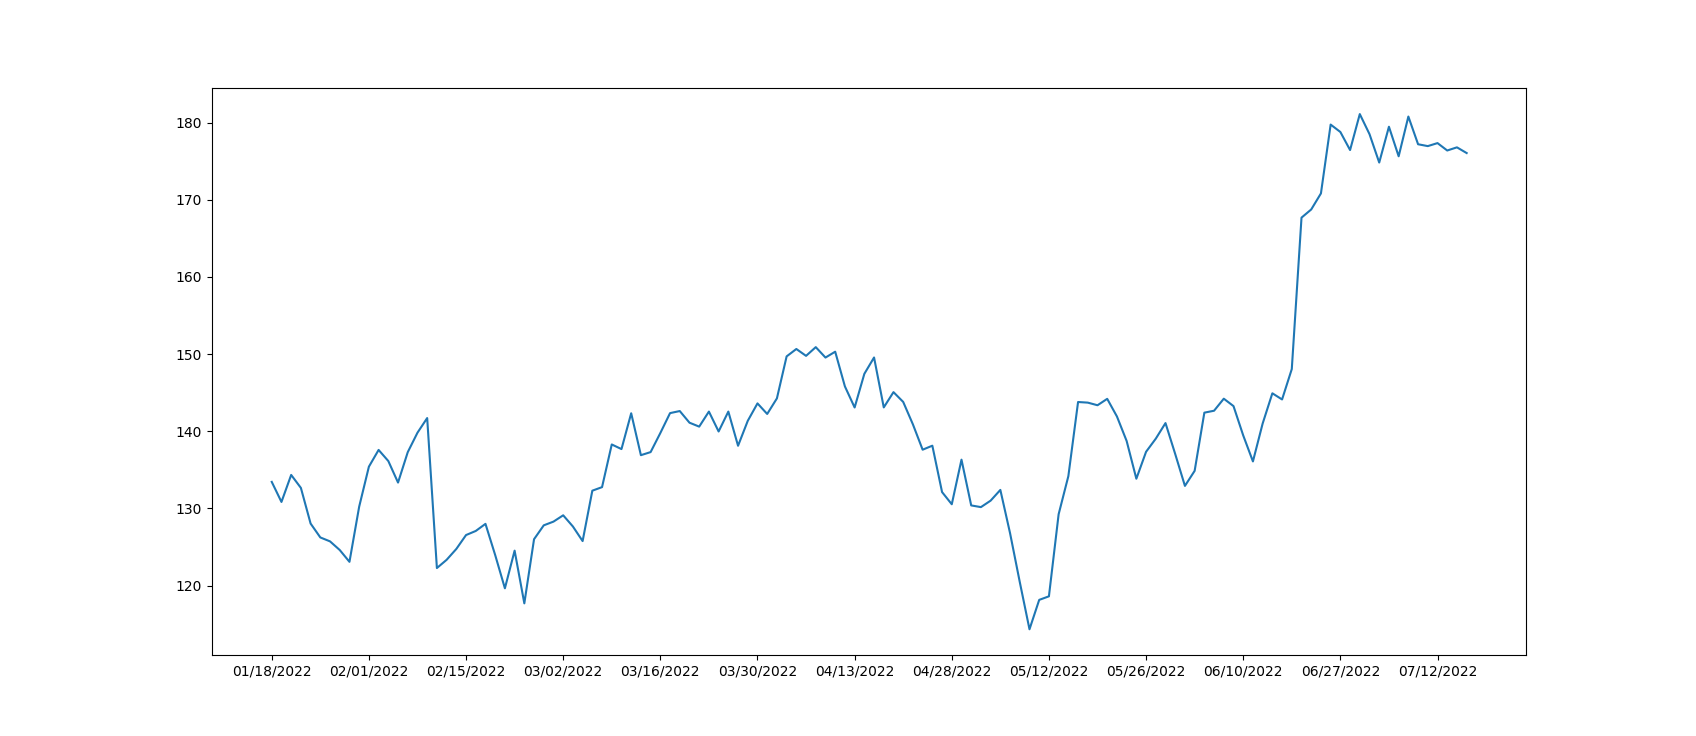

In [132]:
plt.figure()
plt.plot(opens)
plt.xticks(np.arange(len(opens))[::10], test['Date'][::10]);

In [475]:
tickers = pd.read_csv(filepath_or_buffer='/media/rich/bigSSD/aniqa_tmp/stock_tickers.csv', header=None)

In [476]:
tickers = list(tickers[0].astype(str))

In [477]:
tickers.append('XBI')

In [478]:
# Fetch the data
import yfinance as yf
data = yf.download(tickers,'2015-1-1')['Adj Close']

# Print first 5 rows of the data
print(data.head())

[*********************100%***********************]  62 of 62 completed

2 Failed downloads:
- TVST: No data found, symbol may be delisted
- REDX: No data found, symbol may be delisted
                           ABBV   ACET       ACLX  AFMD      ALPMY  ALPN  \
Date                                                                       
2022-02-04 00:00:00  138.172241  12.61  16.799999  3.89  17.309999  7.59   
2022-02-07 00:00:00  140.019119  12.99  17.840000  4.12  17.500000  7.62   
2022-02-08 00:00:00  140.981842  13.59  17.780001  4.22  17.950001  7.49   
2022-02-09 00:00:00  140.677322  15.05  16.400000  4.39  17.639999  7.68   
2022-02-10 00:00:00  140.195953  15.51  16.860001  4.34  17.260000  7.19   

                           AMGN  ARAV       ARVN        ASND  ...        SNY  \
Date                                                          ...              
2022-02-04 00:00:00  218.466522  1.95  69.349998  121.809998  ...  50.108929   
2022-02-07 00:00:00  219.863235  2.17  71.3

In [429]:
stock_infos = [yf.Ticker(ticker).info for ticker in tqdm(tickers)]

  0%|          | 0/62 [00:00<?, ?it/s]

In [468]:
def tryMCap(info):
    try:
        return info['marketCap']
    except:
        return None

marketCaps = np.array([tryMCap(info) for info in tqdm(stock_infos)])[:-1]
marketCaps = np.array([np.nan if cap is None else cap for cap in marketCaps], dtype=np.float64)

  0%|          | 0/62 [00:00<?, ?it/s]

In [479]:
len(marketCaps)

61

In [480]:
data = data.sort_index()

In [481]:
etf = data.pop('XBI')

In [482]:
stocks = data

In [483]:
etf.iloc[-10:]

Date
2022-07-01 00:00:00    76.540001
2022-07-05 00:00:00    80.989998
2022-07-06 00:00:00    81.010002
2022-07-07 00:00:00    83.459999
2022-07-08 00:00:00    84.430000
2022-07-11 00:00:00    80.690002
2022-07-12 00:00:00    81.870003
2022-07-13 00:00:00    83.239998
2022-07-14 00:00:00    81.320000
2022-07-15 00:00:00    82.370003
Name: XBI, dtype: float64

In [1234]:
import matplotlib

traces_stocks = stocks.iloc[-40:-20]
traces_etf = etf.iloc[-40:-20]

theta, y_rec, bias = linear_regression.OLS(np.array(traces_etf), np.array(traces_stocks), add_bias_terms=True)
traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / np.array(traces_stocks)[:7,:].mean(0), index=traces_stocks.index)
# traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / marketCaps, index=traces_stocks.index)
traces_stocks_esr_ms = traces_stocks_esr - traces_stocks_esr[:7].mean(0)

plt.figure()
# plt.plot((traces_stocks / traces_stocks.mean(0)).iloc[:,47]);
# plt.plot(np.array(traces_stocks)[:,47]);
# plt.plot(y_rec[:,47])
plt.plot(traces_stocks_esr_ms, color=[0,0,0,0.2]);
# plt.plot(traces_stocks_esr_ms.mean(1), linewidth=3, color='k');
# plt.plot(traces_etf)
plt.plot(np.array(['2022-05-26', '2022-05-26'], dtype=np.datetime64), [-1, 1], color=[0, 0, 1, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-03', '2022-06-03'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-08', '2022-06-08'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)

left, bottom, width, height = (np.array(['2022-06-03'], dtype=np.datetime64), -1, 5, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

<IPython.core.display.Javascript object>

In [1235]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/preConferenceNormalized_timeline.jpg')

In [1236]:
import matplotlib

traces_stocks = stocks.iloc[-40:]
traces_etf = etf.iloc[-40:]

theta, y_rec, bias = linear_regression.OLS(np.array(traces_etf), np.array(traces_stocks), add_bias_terms=True)
traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / np.array(traces_stocks)[:7,:].mean(0), index=traces_stocks.index)
# traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / marketCaps, index=traces_stocks.index)
traces_stocks_esr_ms = traces_stocks_esr - traces_stocks_esr[:7].mean(0)

In [1297]:
plt.figure(figsize=(15,10))
# plt.plot((traces_stocks / traces_stocks.mean(0)).iloc[:,47]);
# plt.plot(np.array(traces_stocks)[:,47]);
# plt.plot(y_rec[:,47])
plt.plot(traces_stocks_esr_ms, color=[0,0,0,0.2]);
# plt.plot(traces_stocks_esr_ms.mean(1), linewidth=3, color='k');
# plt.plot(traces_etf)
plt.plot(np.array(['2022-05-26', '2022-05-26'], dtype=np.datetime64), [-1, 1], color=[0, 0, 1, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-03', '2022-06-03'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-08', '2022-06-08'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)

left, bottom, width, height = (np.array(['2022-06-03'], dtype=np.datetime64), -1, 5, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-05-18'], dtype=np.datetime64), -1, 8, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="grey")
plt.gca().add_patch(rect)
left, bottom, width, height = (np.array(['2022-05-27'], dtype=np.datetime64), -1, 1, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-07-05'], dtype=np.datetime64), -1, 10, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="yellow")
plt.gca().add_patch(rect)

<IPython.core.display.Javascript object>

In [1298]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/abstractResponse_timeline.jpg')

In [1239]:
score_abstract = traces_stocks_esr_ms.iloc[8]
score_prePost = traces_stocks_esr_ms.iloc[30:].mean(0)

In [1242]:
plt.figure()
plt.scatter(score_abstract, score_prePost)
plt.plot([-0.6, 0.6], [0,0], color=[0,0,0,0.2])
plt.plot([0,0], [-0.45, 0.8], color=[0,0,0,0.2])
plt.xlabel('% change abstract')
plt.ylabel('% change 1.5 months')

<IPython.core.display.Javascript object>

Text(0, 0.5, '% change 1.5 months')

In [1243]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/score_abstract_vs_post.jpg')

In [1244]:
import matplotlib

traces_stocks = stocks.iloc[-40:-20]
traces_etf = etf.iloc[-40:-20]

theta, y_rec, bias = linear_regression.OLS(np.array(traces_etf), np.array(traces_stocks), add_bias_terms=True)
traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / np.array(traces_stocks)[:7,:].mean(0), index=traces_stocks.index)
# traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / marketCaps, index=traces_stocks.index)
traces_stocks_esr_ms = traces_stocks_esr - traces_stocks_esr[8:11].mean(0)

plt.figure(figsize=(15,10))
# plt.plot((traces_stocks / traces_stocks.mean(0)).iloc[:,47]);
# plt.plot(np.array(traces_stocks)[:,47]);
# plt.plot(y_rec[:,47])
plt.plot(traces_stocks_esr_ms, color=[0,0,0,0.2]);
# plt.plot(traces_stocks_esr_ms.mean(1), linewidth=3, color='k');
# plt.plot(traces_etf)
plt.plot(np.array(['2022-05-26', '2022-05-26'], dtype=np.datetime64), [-1, 1], color=[0, 0, 1, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-03', '2022-06-03'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-08', '2022-06-08'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)

left, bottom, width, height = (np.array(['2022-06-03'], dtype=np.datetime64), -1, 5, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

<IPython.core.display.Javascript object>

In [1245]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/prePresentationNormalized_timeline.jpg')

In [1295]:
import matplotlib

traces_stocks = stocks.iloc[-40:]
traces_etf = etf.iloc[-40:]

theta, y_rec, bias = linear_regression.OLS(np.array(traces_etf), np.array(traces_stocks), add_bias_terms=True)
traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / np.array(traces_stocks)[:7,:].mean(0), index=traces_stocks.index)
# traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / marketCaps, index=traces_stocks.index)
traces_stocks_esr_ms = traces_stocks_esr - traces_stocks_esr[:7].mean(0)

plt.figure(figsize=(15,10))
# plt.plot((traces_stocks / traces_stocks.mean(0)).iloc[:,47]);
# plt.plot(np.array(traces_stocks)[:,47]);
# plt.plot(y_rec[:,47])
plt.plot(traces_stocks_esr_ms, color=[0,0,0,0.2]);
# plt.plot(traces_stocks_esr_ms.mean(1), linewidth=3, color='k');
# plt.plot(traces_etf)
plt.plot(np.array(['2022-05-26', '2022-05-26'], dtype=np.datetime64), [-1, 1], color=[0, 0, 1, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-03', '2022-06-03'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-08', '2022-06-08'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)

left, bottom, width, height = (np.array(['2022-06-03'], dtype=np.datetime64), -1, 5, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-05-27'], dtype=np.datetime64), -1, 7, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="grey")
plt.gca().add_patch(rect)
left, bottom, width, height = (np.array(['2022-05-18'], dtype=np.datetime64), -1, 8, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-07-05'], dtype=np.datetime64), -1, 10, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="yellow")
plt.gca().add_patch(rect)

<IPython.core.display.Javascript object>

In [1296]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/abstractPredictiveness_timeline.jpg')

In [1289]:
score_PostabstractPost = traces_stocks_esr_ms.iloc[30:40].mean(0) - traces_stocks_esr_ms.iloc[8:11].mean(0)

In [1290]:
plt.figure()
plt.scatter(score_abstract, score_PostabstractPost)
plt.plot([-0.6, 0.6], [0,0], color=[0,0,0,0.2])
plt.plot([0,0], [-0.2, 0.65], color=[0,0,0,0.2])
plt.xlabel('% change abstract')
plt.ylabel('% change after abstract until 1.5 months')

<IPython.core.display.Javascript object>

Text(0, 0.5, '% change after abstract until 1.5 months')

In [1254]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/score_abstract_vs_postAbstractLongTerm.jpg')

In [1260]:
import matplotlib

traces_stocks = stocks.iloc[-40:]
traces_etf = etf.iloc[-40:]

theta, y_rec, bias = linear_regression.OLS(np.array(traces_etf), np.array(traces_stocks), add_bias_terms=True)
traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / np.array(traces_stocks)[:7,:].mean(0), index=traces_stocks.index)
# traces_stocks_esr = pd.DataFrame((np.array(traces_stocks) - y_rec) / marketCaps, index=traces_stocks.index)
traces_stocks_esr_ms = traces_stocks_esr - traces_stocks_esr[:7].mean(0)

plt.figure(figsize=(15,10))
# plt.plot((traces_stocks / traces_stocks.mean(0)).iloc[:,47]);
# plt.plot(np.array(traces_stocks)[:,47]);
# plt.plot(y_rec[:,47])
plt.plot(traces_stocks_esr_ms, color=[0,0,0,0.2]);
# plt.plot(traces_stocks_esr_ms.mean(1), linewidth=3, color='k');
# plt.plot(traces_etf)
plt.plot(np.array(['2022-05-26', '2022-05-26'], dtype=np.datetime64), [-1, 1], color=[0, 0, 1, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-03', '2022-06-03'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)
# plt.plot(np.array(['2022-06-08', '2022-06-08'], dtype=np.datetime64), [-1, 1], color=[1, 0, 0, 0.2], linewidth=3)

left, bottom, width, height = (np.array(['2022-06-03'], dtype=np.datetime64), -1, 5, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-05-27'], dtype=np.datetime64), -1, 7, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="grey")
plt.gca().add_patch(rect)
left, bottom, width, height = (np.array(['2022-06-08'], dtype=np.datetime64), -1, 3, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)

left, bottom, width, height = (np.array(['2022-07-05'], dtype=np.datetime64), -1, 10, 2)
rect=matplotlib.patches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="yellow")
plt.gca().add_patch(rect)

<IPython.core.display.Javascript object>

In [1261]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/presentationResponse_timeline.jpg')

In [1277]:
score_PostpresentationPostabstract = traces_stocks_esr_ms.iloc[15:18].mean(0) - traces_stocks_esr_ms.iloc[8:11].mean(0)

In [1292]:
plt.figure()
plt.scatter(score_PostpresentationPostabstract, score_PostabstractPost)
plt.plot([-0.25, 1.25], [0,0], color=[0,0,0,0.2])
plt.plot([0,0], [-0.25, 0.35], color=[0,0,0,0.2])
plt.xlabel('% change presentation')
plt.ylabel('% change after abstract until 1.5 months')

<IPython.core.display.Javascript object>

Text(0, 0.5, '% change after abstract until 1.5 months')

In [1293]:
plt.savefig('/media/rich/bigSSD/downloads_tmp/score_presentation_vs_postAbstractLongTerm.jpg')

In [1294]:
traces_stocks_esr_ms.columns = traces_stocks.columns

In [1222]:
traces_stocks_esr_ms.to_csv(path_or_buf='/media/rich/bigSSD/downloads_tmp/traces_stocks_esr_ms.csv')